# SF Bay Area Dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle 


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

%matplotlib inline
init_notebook_mode(connected=True)

### Data is only looking at startups in SF from 2004-2014

In [8]:
df1 = pd.read_csv('startups_sf_2004-14_data.csv')
print("Years in dataset", sorted(list(df1['funded_year'].unique())))

Years in dataset [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


In [7]:
df1.head(5)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,investor_permalink,fILIPPO Murroni,...,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/organization/virtuallogix,VirtualLogix,|Mobile|Virtualization|Software|,Software,USA,CA,SF Bay Area,Sunnyvale,/organization/atlas-venture,Atlas Venture,...,Boston,Cambridge,/funding-round/8534a4893af02254af3104fa91a4cdbf,venture,A,2004-01-01,2004-01,2004-Q1,2004,12000000.0
1,/organization/virtuallogix,VirtualLogix,|Mobile|Virtualization|Software|,Software,USA,CA,SF Bay Area,Sunnyvale,/organization/cisco,Cisco,...,SF Bay Area,San Jose,/funding-round/8534a4893af02254af3104fa91a4cdbf,venture,A,2004-01-01,2004-01,2004-Q1,2004,12000000.0
2,/organization/deem,Deem,|Trading|Marketplaces|Content Syndication|Prod...,E-Commerce,USA,CA,SF Bay Area,San Francisco,/organization/empire-capital-partners,Empire Capital Partners,...,Hartford,Westport,/funding-round/dc687f1c43ce40715ec25416113fbd62,venture,NaN,2004-01-01,2004-01,2004-Q1,2004,42000000.0
3,/organization/deem,Deem,|Trading|Marketplaces|Content Syndication|Prod...,E-Commerce,USA,CA,SF Bay Area,San Francisco,/organization/foundation-capital,Foundation Capital,...,SF Bay Area,Menlo Park,/funding-round/dc687f1c43ce40715ec25416113fbd62,venture,NaN,2004-01-01,2004-01,2004-Q1,2004,42000000.0
4,/organization/virtuallogix,VirtualLogix,|Mobile|Virtualization|Software|,Software,USA,CA,SF Bay Area,Sunnyvale,/organization/index-ventures,Index Ventures,...,Geneva,Geneva,/funding-round/8534a4893af02254af3104fa91a4cdbf,venture,A,2004-01-01,2004-01,2004-Q1,2004,12000000.0


Import Amount Raised Per Company

In [9]:
with open('funding_dict.pickle', 'rb') as handle:
    funding_dict = pickle.load(handle)

In [10]:
len(funding_dict)

22747

In [11]:
names_unique = df1['company_name'].drop_duplicates()

In [12]:
len(names_unique)

4585

Create dict for company market

In [13]:
market_df = df1[['company_name', 'company_market']]
market_df = market_df.drop_duplicates()

market_dict = dict(zip(list(market_df.company_name),list(market_df.company_market)))

In [14]:
len(market_dict)

4585

Create dict for cities

In [15]:
city_df = df1[['company_name', 'company_city']]
city_df = city_df.drop_duplicates()

city_dict = dict(zip(list(city_df.company_name),list(city_df.company_city)))

In [16]:
len(city_dict)

4585

Building a cleaned dataframe for analysis and modeling

In [17]:
data_cleaned = pd.DataFrame()
data_cleaned = pd.concat([names_unique, pd.Series(list(names_unique.map(funding_dict))), pd.Series(list(names_unique.map(market_dict))),pd.Series(list(names_unique.map(city_dict)))],axis=1)

In [18]:
data_cleaned = data_cleaned.dropna()
data_cleaned = data_cleaned.reset_index(drop=True)

In [19]:
data_cleaned.rename(columns={0:'total_funding', 1:'company_market', 2:'company_city'},inplace=True);
print(data_cleaned.shape)
data_cleaned.head(5)

(1140, 4)


,company_name,total_funding,company_market,company_city
0,VirtualLogix,29.288979,Software,Sunnyvale
1,Deem,56.300000,Broadcasting,Oakland
2,Pandora Media,32.000000,Hotels,Santa Clara
3,PlayFirst,5.800000,Music,San Francisco
4,Socialtext,3.000000,iPhone,Mountain View


Looking for top funded companies

In [20]:
from heapq import nlargest
largest = nlargest(50, funding_dict, key=funding_dict.get)
print(largest) 

['Verizon Communications', 'Sberbank', 'Clearwire', 'sigmacare', 'Facebook', 'Flipkart', 'Solyndra', 'Uber', 'Venari Resources', 'Fisker Automotive', 'O3b Networks', 'Youku', 'Cloudera', 'Cape Wind', 'Twitter', 'Groupon', 'Alibaba', 'Dropbox', 'Snapdeal', 'Wave Broadband', 'SolarCity', 'AOL', 'BlackBerry', 'Bloom Energy', 'Palantir Technologies', 'LivingSocial', 'Better Place', 'SurveyMonkey', '58.com', 'Zynga', 'BrightSource Energy', 'FireEye', 'Tesla Motors', 'Airbnb', 'Pinterest', 'University of Maryland', 'BMC Software', 'Chobani', 'Alnylam Pharmaceuticals', 'PPTV', 'Lazada Group', 'Delivery Hero', 'SunEdison', 'Tamra-Tacoma Capital Partners', 'Helios Towers Africa', 'Enel OGK-5', 'IHS Holding', 'Magic Leap', 'Square', 'ZeniMax']


Looking for most popular markets

In [21]:
grouped_df1 = data_cleaned.groupby(['company_market'])['total_funding']

In [22]:
keys_market = []
funding = []
market_funding_dict = {}
for key, item in grouped_df1:
    keys_market.append(key)
    market_funding_dict[key] = sum(grouped_df1.get_group(key))

In [23]:
from heapq import nlargest
largest = nlargest(20, market_funding_dict, key=market_funding_dict.get)
print(largest) 

['Clean Technology', 'Analytics', 'Software', 'Biotechnology', 'Transportation', 'Health Care', 'Cloud Data Services', 'Semiconductors', 'Enterprise Software', 'Advertising', 'Construction', 'Automotive', 'Security', 'Mobile', 'Network Security', 'Technology', 'Web Hosting', 'Communications Hardware', 'Curated Web', 'Games']


In [24]:
funding_in_markets_bar = [go.Bar(
            x=largest,
            y=[market_funding_dict[x]/1e3 for x in largest]
    )]

iplot({'data':funding_in_markets_bar, 'layout':{'title': 'Total Investments Per Markets 2004-2014',
                          'font': dict(size=11),
                          'yaxis': dict(title='Total Funding in Billions')}}, filename='basic-bar')

### Looking at average raised per round

In [25]:
grouped_df3 = df1.groupby(['company_name'])['funding_round_code']

In [26]:
funding_rounds_dict = {}
for key, item in grouped_df3:
    funding_rounds_dict[key] = set(grouped_df3.get_group(key))

### Create an order for the rounds, create a dictionary for the max round per startup

In [28]:
round_dict = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8}

In [29]:
def enum_round(round_,dictionary):
    if round_ in list(dictionary.keys()):
        return dictionary[round_]
    else:
        return (0)
        

In [30]:
max_funding_dict = {}
for company in funding_rounds_dict.keys():
    max_funding_dict[company] = max([enum_round(round_, round_dict) for round_ in funding_rounds_dict[company]])

In [31]:
data_cleaned['company_max_round'] = data_cleaned['company_name'].map(max_funding_dict)

In [32]:
rounds_flatten =  [y for x in list(funding_rounds_dict.values()) for y in x]

In [33]:
from collections import Counter
rounds_sums_dict = Counter(rounds_flatten)

## Number of Startups In Each Round

In [34]:
avg_funding_per_round_bar = [go.Bar(
            x=list(rounds_sums_dict.keys()),
            y=list(rounds_sums_dict.values())
    )]

iplot({'data':avg_funding_per_round_bar, 'layout':{'title': 'Amount of Companies with Funding Between 2004-2014',
                          'font': dict(size=11)}}, filename='basic-bar')

## Companies With The Most Funding

In [35]:
most_funded_companies = nlargest(20, funding_dict, key=funding_dict.get)
print(most_funded_companies) 

['Verizon Communications', 'Sberbank', 'Clearwire', 'sigmacare', 'Facebook', 'Flipkart', 'Solyndra', 'Uber', 'Venari Resources', 'Fisker Automotive', 'O3b Networks', 'Youku', 'Cloudera', 'Cape Wind', 'Twitter', 'Groupon', 'Alibaba', 'Dropbox', 'Snapdeal', 'Wave Broadband']


In [36]:
company_funding_bar = [go.Bar(
            x=list(most_funded_companies),
            y=list([funding_dict[x] for x in most_funded_companies])
    )]

iplot({'data':company_funding_bar, 'layout':{'title': 'Start Ups With Funding Between 2004-2014 (Millions)',
                          'font': dict(size=11)}}, filename='basic-bar')

In [37]:
data_cleaned.columns

Index(['company_name', 'total_funding', 'company_market', 'company_city',
       'company_max_round'],
      dtype='object')

In [38]:
df_base = df1[['company_name','company_market','company_city']]
df_base.drop_duplicates();

In [39]:
df_base = df_base[df_base['company_city']=='San Francisco'];
df_base.reset_index;

## Bringing In Acquisition + IPO Data As The Target

In [40]:
with open('master_list.pickle', 'rb') as handle:
    master_list = pickle.load(handle)

In [43]:
# Create a dataframe of all acquisitions
df_acq = pd.read_csv('acquisitions_data.csv')

# List of all companies that have been acquired
acquired_list = master_list

In [45]:
df_acq.head(5)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,...,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/organization/magnify,Waywire Networks,...,USA,NY,New York City,New York,2013-10-17 00:00:00,2013-10,2013-Q4,2013.0,NaN,USD
1,/organization/fluff-friends,(fluff)Friends,NaN,NaN,NaN,NaN,NaN,NaN,/organization/social-gaming-network,SGN (Social Gaming Network),...,USA,CA,Los Angeles,Beverly Hills,2008-09-16 00:00:00,2008-09,2008-Q3,2008.0,NaN,USD
2,/organization/red,(RED),|Nonprofits|,Nonprofits,USA,NY,New York City,New York,/organization/nationstar-mortgage-holdings,Nationstar Mortgage Holdings,...,USA,TX,Dallas,Lewisville,2014-05-08 00:00:00,2014-05,2014-Q2,2014.0,18000000.0,USD
3,/organization/vandaele-holdings,.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/hi7e,HI7E,...,USA,FL,Palm Beaches,West Palm Beach,2011-01-01 00:00:00,2011-01,2011-Q1,2011.0,NaN,USD
4,/organization/co-internet,.CO,|Registrars|Domains|Curated Web|,Registrars,USA,FL,Miami,Miami,/organization/neustar,Neustar,...,USA,VA,"Washington, D.C.",Sterling,2014-03-20 00:00:00,2014-03,2014-Q1,2014.0,109000000.0,USD


In [46]:
print(len(set(list(df_acq['company_name']))))
len(set(master_list))

12784


12858

In [47]:
# Function to check whether a company has been acquired or not.

def acquired_check(i):
    if i in acquired_list:
        return 1
    else: 
        return 0

In [48]:
data_cleaned['isAcquired'] = data_cleaned['company_name'].map(acquired_check);

In [49]:
(data_cleaned[data_cleaned['isAcquired']==1]['isAcquired']).shape

(404,)

In [50]:
data_cleaned.reset_index;

In [51]:
print(data_cleaned.columns)
print(data_cleaned.shape)

Index(['company_name', 'total_funding', 'company_market', 'company_city',
       'company_max_round', 'isAcquired'],
      dtype='object')
(1140, 6)


## Finding Most Popular Cities

In [52]:
popular_cities= data_cleaned['company_city'].value_counts()
popular_cities.keys()

Index(['San Francisco', 'Palo Alto', 'Mountain View', 'Santa Clara',
       'San Mateo', 'San Jose', 'Sunnyvale', 'Redwood City', 'Menlo Park',
       'Fremont', 'Cupertino', 'Oakland', 'Milpitas', 'Berkeley', 'Emeryville',
       'Foster City', 'Campbell', 'South San Francisco', 'Los Gatos',
       'Hayward', 'San Carlos', 'Pleasanton', 'Newark', 'Burlingame',
       'San Rafael', 'Alameda', 'Belmont', 'San Ramon', 'Brisbane',
       'San Leandro', 'Redwood Shores', 'Los Altos', 'Larkspur', 'Millbrae',
       'Santa Cruz', 'Richmond', 'Corte Madera', 'Novato', 'San Bruno',
       'Los Altos Hills', 'Mill Valley', 'Livermore', 'Stanford', 'Sausalito',
       'Benicia', 'Scotts Valley', 'Portola Valley'],
      dtype='object')

In [53]:
popular_cities_bar = [go.Bar(
            x=popular_cities.keys()[:10],
            y=[popular_cities[key] for key in popular_cities.keys()[:10]]
    )]

iplot({'data':popular_cities_bar, 'layout':{'title': 'Most Popular Markets in SF',
                          'font': dict(size=11)}}, filename='basic-bar')

In [54]:
from collections import Counter
grouped_city = data_cleaned.groupby(['company_city'])['isAcquired']

city_popular_dict = {}

for key, item in grouped_city:
    city_popular_dict[key] = Counter(grouped_city.get_group(key))

acquired_pop_cities = [city_popular_dict[key][1] for key in popular_cities.keys()]
not_acquired_pop_cities = [city_popular_dict[key][0] for key in popular_cities.keys()]

In [55]:
trace1 = go.Bar(
    x=popular_cities.keys()[:10],
    y=acquired_pop_cities[:10],
    name='Acquired'
)
trace2 = go.Bar(
    x=popular_cities.keys()[:10],
    y=not_acquired_pop_cities[:10],
    name='Not Acquired'
)
    
data = [trace1, trace2]
layout = go.Layout(
    title ='Most Popular Bay Area Cities For Startups ',
    barmode='stack',
    xaxis=dict(title='City'),
    yaxis=dict(title='Number of Startups')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

In [56]:
def otherizer_city(string):

    if string not in popular_cities.keys()[:9]:
        return 'Other_city'
    else:
        return string

In [57]:
data_cleaned['company_city_popular'] = data_cleaned['company_city'].map(otherizer_city)

In [58]:
data_cleaned['company_city_popular'].describe()

count              1140
unique               10
top       San Francisco
freq                428
Name: company_city_popular, dtype: object

In [59]:
data_cleaned.head(10)

,company_name,total_funding,company_market,company_city,company_max_round,isAcquired,company_city_popular
0,VirtualLogix,29.288979,Software,Sunnyvale,2,1,Sunnyvale
1,Deem,56.300000,Broadcasting,Oakland,8,0,Other_city
2,Pandora Media,32.000000,Hotels,Santa Clara,4,0,Santa Clara
3,PlayFirst,5.800000,Music,San Francisco,3,1,San Francisco
4,Socialtext,3.000000,iPhone,Mountain View,4,1,Mountain View
5,SideStep,33.400000,Music,Emeryville,3,1,Other_city
6,Soundflavor,28.300000,Curated Web,Sunnyvale,1,0,Sunnyvale
7,Executive Caddie,823.000000,Automotive,Palo Alto,0,0,Palo Alto
8,VisualOn,80.540000,Health Care,Mountain View,2,0,Mountain View
9,Innovative Silicon,62.000000,Health Care,Campbell,3,0,Other_city


## Finding Most Popular Market

In [60]:
popular_markets= data_cleaned['company_market'].value_counts()
popular_markets.keys()

Index(['Software', 'Biotechnology', 'Mobile', 'Curated Web',
       'Enterprise Software', 'Advertising', 'Health Care', 'Semiconductors',
       'Clean Technology', 'Games',
       ...
       'Fraud Detection', 'Professional Services', 'Monetization', 'PaaS',
       'Enterprise Application', 'Bitcoin', 'Electronics', 'Cloud Security',
       'Gamification', 'Doctors'],
      dtype='object', length=246)

In [61]:
from collections import Counter
popular_markets_acq = data_cleaned.groupby(['company_market'])['isAcquired']

popular_markets_acq_dict = {}

for key, item in popular_markets_acq:
    popular_markets_acq_dict[key] = Counter(popular_markets_acq.get_group(key))
    
acquired_markets = [popular_markets_acq_dict[key][1] for key in popular_markets.keys()[:30]]
not_acquired_markets = [popular_markets_acq_dict[key][0] for key in popular_markets.keys()[:30]]

In [62]:
trace1 = go.Bar(
    x=popular_markets.keys()[:10],
    y=acquired_markets[:10],
    name='Acquired'
)
trace2 = go.Bar(
    x=popular_markets.keys()[:10],
    y=not_acquired_markets[:10],
    name='Not Acquired'
)
    
data = [trace1, trace2]
layout = go.Layout(
    title ='Most Popular Markets in SF',
    barmode='stack',
    xaxis=dict(title='Market'),
    yaxis=dict(title='Number of Startups')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

In [63]:
def otherizer_markets(string):

    if string not in popular_markets.keys()[:30]:
        return 'Other_market'
    else:
        return string

In [64]:
data_cleaned['company_market_popular'] = data_cleaned['company_market'].map(otherizer_markets)

In [65]:
data_cleaned['company_market_popular'].describe()

count             1140
unique              31
top       Other_market
freq               361
Name: company_market_popular, dtype: object

In [66]:
popular_markets_bar = [go.Bar(
            x=popular_markets.keys()[:30],
            y=[popular_markets[key] for key in popular_markets.keys()[:30]]
    )]

iplot({'data':popular_markets_bar, 'layout':{'title': 'Most Popular Markets in SF',
                          'font': dict(size=11)}}, filename='basic-bar')

## Including Investor Rank

In [67]:
with open('investor_rating_dict.pickle', 'rb') as handle:
    investor_rating_dict = pickle.load(handle)

In [68]:
data_cleaned['investor_ratings'] = data_cleaned['company_name'].map(investor_rating_dict)

## Create Dummy Variables For Categorical Data

In [69]:
from sklearn.preprocessing import MultiLabelBinarizer
def bin_multi_label(dataframe,column_name):
    data_ = dataframe[column_name].value_counts()

    list_ = [[i] for i in list(dataframe[column_name])]

    one_hot = MultiLabelBinarizer()
    one_hot.fit([list(data_.index)]) 
    one_hot_data_= one_hot.transform(list_)

    model_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)

    return one_hot, model_df

In [70]:
mlb_market,market_df = bin_multi_label(data_cleaned,'company_market_popular');
mlb_city,city_df = bin_multi_label(data_cleaned,'company_city_popular');

In [71]:
data_cleaned['isAcquired'].describe()

count    1140.000000
mean        0.354386
std         0.478537
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: isAcquired, dtype: float64

In [72]:
print(market_df.shape,data_cleaned['total_funding'].shape)

(1140, 31) (1140,)


In [73]:
data_cleaned.head(10)

,company_name,total_funding,company_market,company_city,company_max_round,isAcquired,company_city_popular,company_market_popular,investor_ratings
0,VirtualLogix,29.288979,Software,Sunnyvale,2,1,Sunnyvale,Software,10.000000
1,Deem,56.300000,Broadcasting,Oakland,8,0,Other_city,Other_market,9.821429
2,Pandora Media,32.000000,Hotels,Santa Clara,4,0,Santa Clara,Other_market,9.727273
3,PlayFirst,5.800000,Music,San Francisco,3,1,San Francisco,Music,10.000000
4,Socialtext,3.000000,iPhone,Mountain View,4,1,Mountain View,Other_market,9.818182
5,SideStep,33.400000,Music,Emeryville,3,1,Other_city,Music,10.000000
6,Soundflavor,28.300000,Curated Web,Sunnyvale,1,0,Sunnyvale,Curated Web,7.400000
7,Executive Caddie,823.000000,Automotive,Palo Alto,0,0,Palo Alto,Other_market,6.000000
8,VisualOn,80.540000,Health Care,Mountain View,2,0,Mountain View,Health Care,7.500000
9,Innovative Silicon,62.000000,Health Care,Campbell,3,0,Other_city,Health Care,10.000000


In [74]:
with open('city_funding_df.pkl', 'rb') as handle:
    city_funding_dict = pickle.load(handle)

In [75]:
data_cleaned['city_funding'] = data_cleaned['company_city'].map(city_funding_dict)

In [76]:
data_cleaned.head(10)

,company_name,total_funding,company_market,company_city,company_max_round,isAcquired,company_city_popular,company_market_popular,investor_ratings,city_funding
0,VirtualLogix,29.288979,Software,Sunnyvale,2,1,Sunnyvale,Software,10.000000,2.578153e+10
1,Deem,56.300000,Broadcasting,Oakland,8,0,Other_city,Other_market,9.821429,4.780534e+09
2,Pandora Media,32.000000,Hotels,Santa Clara,4,0,Santa Clara,Other_market,9.727273,2.146238e+10
3,PlayFirst,5.800000,Music,San Francisco,3,1,San Francisco,Music,10.000000,1.419265e+11
4,Socialtext,3.000000,iPhone,Mountain View,4,1,Mountain View,Other_market,9.818182,3.288362e+10
5,SideStep,33.400000,Music,Emeryville,3,1,Other_city,Music,10.000000,2.501729e+09
6,Soundflavor,28.300000,Curated Web,Sunnyvale,1,0,Sunnyvale,Curated Web,7.400000,2.578153e+10
7,Executive Caddie,823.000000,Automotive,Palo Alto,0,0,Palo Alto,Other_market,6.000000,3.425338e+10
8,VisualOn,80.540000,Health Care,Mountain View,2,0,Mountain View,Health Care,7.500000,3.288362e+10
9,Innovative Silicon,62.000000,Health Care,Campbell,3,0,Other_city,Health Care,10.000000,4.409666e+09


In [77]:
data_encoded = pd.concat([market_df,city_df,data_cleaned['city_funding'],data_cleaned['investor_ratings'],data_cleaned['company_max_round'],data_cleaned['total_funding'],data_cleaned['isAcquired']], axis=1,sort=False)

In [78]:
print('shape',data_encoded.shape) 

shape (1140, 46)


In [79]:
data_encoded = data_encoded[data_encoded['investor_ratings'].isna() != True]
data_encoded = data_encoded[data_encoded['city_funding'].isna() != True]

In [80]:
data_encoded.columns

Index(['Advertising', 'Analytics', 'Big Data', 'Biotechnology',
       'Clean Technology', 'Cloud Computing', 'Curated Web', 'E-Commerce',
       'Education', 'Enterprise Software', 'Finance', 'Games',
       'Hardware + Software', 'Health Care', 'Health and Wellness',
       'Internet of Things', 'Mobile', 'Music', 'News', 'Other_market',
       'Photography', 'SaaS', 'Search', 'Security', 'Semiconductors',
       'Social Media', 'Social Network Media', 'Software', 'Technology',
       'Video', 'Web Hosting', 'Menlo Park', 'Mountain View', 'Other_city',
       'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose', 'San Mateo',
       'Santa Clara', 'Sunnyvale', 'city_funding', 'investor_ratings',
       'company_max_round', 'total_funding', 'isAcquired'],
      dtype='object')

## Testing A Logistic Regression Model With Base Data

Metrics interpretations

1) **Precision** - We don't want to spend money on startups that will fail

2) **Recall** - Minimizing missed opportunities 

**Accuracy** - We want to ideally correctly identify all startups

**False Negative** - We missed out on very good opportunities 

## Check class imbalance

In [81]:
acquired_stats = data_encoded['isAcquired'].describe()
print(acquired_stats)

count    1132.000000
mean        0.355124
std         0.478762
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: isAcquired, dtype: float64


In [82]:
mean_ = acquired_stats['mean']
count_ = acquired_stats['count']

In [83]:
trace1 = go.Bar(
    x=['Successful'],
    y=[count_*mean_],
    name='Successful'
)
trace2 = go.Bar(
    x=['Unsuccessful'],
    y=[count_*(1-mean_)],
    name='Unsuccessful'
)
    
data = [trace2,trace1]
layout = go.Layout(
    title ='Most Popular Markets in SF',
    yaxis=dict(title='Number of Startups')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

## Prepare Data From Model

In [84]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y = data_encoded.pop('isAcquired')
X = data_encoded
print(y.shape,X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444,stratify=y)


(1132,) (1132, 45)


In [85]:
X.describe()

,Advertising,Analytics,Big Data,Biotechnology,Clean Technology,Cloud Computing,Curated Web,E-Commerce,Education,Enterprise Software,...,Redwood City,San Francisco,San Jose,San Mateo,Santa Clara,Sunnyvale,city_funding,investor_ratings,company_max_round,total_funding
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,...,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1.132000e+03,1132.000000,1132.000000,1132.000000
mean,0.032686,0.019435,0.008834,0.053004,0.023852,0.006184,0.053887,0.021201,0.015018,0.048587,...,0.048587,0.373675,0.053004,0.053004,0.065371,0.051237,6.554944e+10,9.551948,2.480565,33.778923
std,0.177891,0.138108,0.093614,0.224140,0.152654,0.078428,0.225894,0.144119,0.121677,0.215097,...,0.215097,0.483993,0.224140,0.224140,0.247289,0.220578,5.973151e+10,1.035308,1.670616,107.393129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.937000e+06,2.000000,0.000000,0.006000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.722861e+10,9.632143,1.000000,2.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.288362e+10,10.000000,2.000000,9.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.419265e+11,10.000000,4.000000,28.776481
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.419265e+11,10.000000,8.000000,1507.450000


In [87]:
X_train.shape

(792, 45)

In [94]:
model = linear_model.LogisticRegression(penalty='l1')
model.fit(X_train, y_train)

# accuracy for test & train:
train_acc=model.score(X_train, y_train)
test_acc=model.score(X_test,y_test)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = y_test
y_pred = model.predict(X_test)


conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n')
print ("Precision:              %0.2f" % precision)
print ("Recall:                 %0.2f"% recall)
print ("F1 Score:               %0.4f"% f1_score)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Training Data Accuracy: 0.67
Test Data Accuracy:     0.64
[[209  10]
 [112   9]]


Precision:              0.47
Recall:                 0.07
F1 Score:               0.1286


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [89]:
len(X.columns)
len(model.coef_)

1

In [90]:
coef = list(zip(list(X.columns),list(model.coef_[0])))  
coef.append(('Intercept',model.intercept_[0]))
coef

[('Advertising', -4.0986385004761124e-24),
 ('Analytics', 5.426007948305792e-25),
 ('Big Data', 1.8239591857518818e-24),
 ('Biotechnology', -3.748301001591857e-24),
 ('Clean Technology', 3.8648417055706095e-24),
 ('Cloud Computing', -1.2895384591336107e-24),
 ('Curated Web', -1.9941063037695192e-23),
 ('E-Commerce', -4.245159292093873e-24),
 ('Education', -8.768442101518282e-25),
 ('Enterprise Software', -4.867048637361969e-24),
 ('Finance', -2.563877031345219e-25),
 ('Games', -1.043309430515906e-23),
 ('Hardware + Software', -1.1385697081806561e-23),
 ('Health Care', -1.0801301923534115e-23),
 ('Health and Wellness', -1.2493631570136293e-23),
 ('Internet of Things', 2.1743778629689293e-24),
 ('Mobile', -4.395781101893931e-24),
 ('Music', 1.2613291217550348e-24),
 ('News', -1.603457225105792e-25),
 ('Other_market', -5.74502824216832e-23),
 ('Photography', 1.008029636926343e-24),
 ('SaaS', -1.1291752371539506e-24),
 ('Search', 2.680701887094101e-24),
 ('Security', -6.721865200402262e-24

0.49256575719838486


<Figure size 432x288 with 0 Axes>

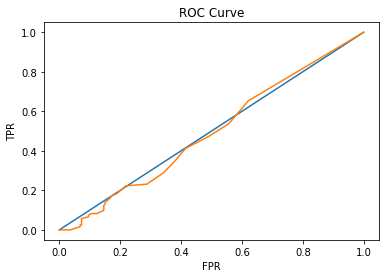

<Figure size 432x288 with 0 Axes>

In [91]:
from sklearn.metrics import roc_curve, auc

y_score=model.predict_proba(X_test)[:,1]

FPR, TPR,thresholds = roc_curve(y_test, y_score)
roc_auc = auc(FPR, TPR)


# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(FPR,TPR)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
print(roc_auc)
plt.figure()

In [92]:
ROC_DATA = list(zip(list(FPR),list(TPR),list(thresholds)))  

## Testing Polynomial Features

In [128]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

for degree in range(3):
    est = make_pipeline(PolynomialFeatures(degree), linear_model.LogisticRegression(class_weight='balanced'))
    
    
    est.fit(X_train, y_train)
    # accuracy for test & train:
    train_acc=model.score(X_train, y_train)
    test_acc=model.score(X_test,y_test)
    
    print(f'Degree {degree}')
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = y_test
    y_pred = est.predict(X_test)


    conf = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf.ravel()

    print(conf)

    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    f1_score = 2*precision*recall/(precision + recall)

    #print ('\n')
    print ("Precision:              %0.2f" % precision)
    print ("Recall:                 %0.2f"% recall)
    print ("F1 Score:               %0.4f"% f1_score)
    print('\n')

    

Degree 0
Training Data Accuracy: 0.67
Test Data Accuracy:     0.64
[[219   0]
 [121   0]]
Precision:              nan
Recall:                 0.00
F1 Score:               nan


Degree 1
Training Data Accuracy: 0.67
Test Data Accuracy:     0.64
[[  0 219]
 [  0 121]]
Precision:              0.36
Recall:                 1.00
F1 Score:               0.5249


Degree 2
Training Data Accuracy: 0.67
Test Data Accuracy:     0.64
[[  0 219]
 [  0 121]]
Precision:              0.36
Recall:                 1.00
F1 Score:               0.5249




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in long_scalars

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



## Optimize wrt F1

RandomSearchCV to find the optimal model


In [97]:
import numpy as np
c_range = list(np.logspace(-3, 1, 256))
param_grid = dict(C=c_range)

In [98]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

grid = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.001, 0.001036779197060366, 0.001074911103457137, 0.0011144454707535626, 0.00115543388033544, 0.0011979298107105216, 0.0012419887072831308, 0.001287668054695046, 0.0013350274518270132, 0.0013841286895587572, 0.0014350358313889448, 0.0014878152970202849, 0.0015425359490188...8.347734492114153, 8.654757464007233, 8.973072494285637, 9.303094895789918, 9.64525525623346, 10.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=True)

In [99]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

LogisticRegression(C=1.766277039966443, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
{'C': 1.766277039966443}
0.16533737031274007


## Optimize wrt Precision

In [100]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

grid = RandomizedSearchCV(model, param_grid, cv=10, scoring='precision', n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.001, 0.001036779197060366, 0.001074911103457137, 0.0011144454707535626, 0.00115543388033544, 0.0011979298107105216, 0.0012419887072831308, 0.001287668054695046, 0.0013350274518270132, 0.0013841286895587572, 0.0014350358313889448, 0.0014878152970202849, 0.0015425359490188...8.347734492114153, 8.654757464007233, 8.973072494285637, 9.303094895789918, 9.64525525623346, 10.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='precision', verbose=True)

In [101]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

LogisticRegression(C=0.8576958985908937, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
{'C': 0.8576958985908937}
0.503663529231711


## Rerunning The Found Optimal Model

In [102]:
model1 = linear_model.LogisticRegression(penalty='l1',C=0.8576958985908937)
model1.fit(X_train, y_train)

# accuracy for test & train:
train_acc=model1.score(X_train, y_train)
test_acc=model1.score(X_test,y_test)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = y_test
y_pred = model1.predict(X_test)


conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n')
print ("Precision:              %0.2f" % precision)
print ("Recall:                 %0.2f"% recall)
print ("F1 Score:               %0.4f"% f1_score)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Training Data Accuracy: 0.67
Test Data Accuracy:     0.64
[[209  10]
 [111  10]]


Precision:              0.50
Recall:                 0.08
F1 Score:               0.1418


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Text(0,0.5,'TPR')

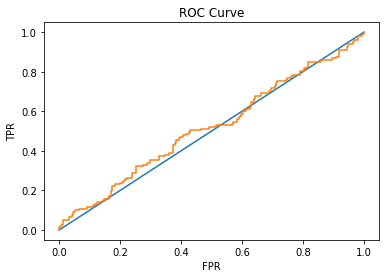

In [103]:
#Make this into a function to generate a ROC curve
y_score=model1.predict_proba(X_test)[:,1]

FPR, TPR, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(FPR, TPR)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(FPR,TPR)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [104]:
roc_auc = auc(FPR, TPR)
roc_auc

0.5175289633571079

## Testing SVM

from sklearn import svm

model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train, y_train)


y_pred = model_svm.predict(X_test)
accuracy_score(y_test,y_pred)

conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n')
print ("Precision:              %0.2f" % precision)
print ("Recall:                 %0.2f" % recall)
print ("F1 Score:               %0.4f" % f1_score)

## Testing A Decision Tree

In [105]:
X.columns

Index(['Advertising', 'Analytics', 'Big Data', 'Biotechnology',
       'Clean Technology', 'Cloud Computing', 'Curated Web', 'E-Commerce',
       'Education', 'Enterprise Software', 'Finance', 'Games',
       'Hardware + Software', 'Health Care', 'Health and Wellness',
       'Internet of Things', 'Mobile', 'Music', 'News', 'Other_market',
       'Photography', 'SaaS', 'Search', 'Security', 'Semiconductors',
       'Social Media', 'Social Network Media', 'Software', 'Technology',
       'Video', 'Web Hosting', 'Menlo Park', 'Mountain View', 'Other_city',
       'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose', 'San Mateo',
       'Santa Clara', 'Sunnyvale', 'city_funding', 'investor_ratings',
       'company_max_round', 'total_funding'],
      dtype='object')

In [106]:
from sklearn import tree

In [107]:
model_tree = tree.DecisionTreeClassifier(class_weight='balanced',max_depth=5)

In [108]:
model_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [109]:
# accuracy for test & train:
train_acc=model_tree.score(X_train, y_train)
test_acc=model_tree.score(X_test,y_test)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_pred = model_tree.predict(X_test)

conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n')
print ("Precision:              %0.2f" % precision)
print ("Recall:                 %0.2f" % recall)
print ("F1 Score:               %0.4f" % f1_score)

Training Data Accuracy: 0.64
Test Data Accuracy:     0.53
[[121  98]
 [ 63  58]]


Precision:              0.37
Recall:                 0.48
F1 Score:               0.4188


Text(0,0.5,'TPR')

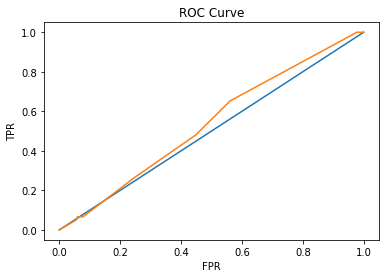

In [110]:
#Make this into a function to generate a ROC curve
y_score=model_tree.predict_proba(X_test)[:,1]

FPR, TPR, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(FPR, TPR)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(FPR,TPR)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

Testing with less dummy variables

In [111]:
X.columns

Index(['Advertising', 'Analytics', 'Big Data', 'Biotechnology',
       'Clean Technology', 'Cloud Computing', 'Curated Web', 'E-Commerce',
       'Education', 'Enterprise Software', 'Finance', 'Games',
       'Hardware + Software', 'Health Care', 'Health and Wellness',
       'Internet of Things', 'Mobile', 'Music', 'News', 'Other_market',
       'Photography', 'SaaS', 'Search', 'Security', 'Semiconductors',
       'Social Media', 'Social Network Media', 'Software', 'Technology',
       'Video', 'Web Hosting', 'Menlo Park', 'Mountain View', 'Other_city',
       'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose', 'San Mateo',
       'Santa Clara', 'Sunnyvale', 'city_funding', 'investor_ratings',
       'company_max_round', 'total_funding'],
      dtype='object')

In [112]:
X_min = X[['investor_ratings', 'company_max_round', 'total_funding']]
X_train, X_test, y_train, y_test = train_test_split(X_min, y, test_size=0.3, random_state=444)

Training Data Accuracy: 0.55
Test Data Accuracy:     0.50
[[ 96 113]
 [ 56  75]]


Precision:              0.40
Recall:                 0.57
F1 Score:               0.4702


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Text(0,0.5,'TPR')

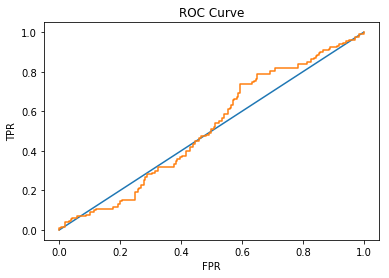

In [113]:
model1 = linear_model.LogisticRegression(class_weight='balanced')
model1.fit(X_train, y_train)

# accuracy for test & train:
train_acc=model1.score(X_train, y_train)
test_acc=model1.score(X_test,y_test)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = y_test
y_pred = model1.predict(X_test)


conf = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf.ravel()

print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n')
print ("Precision:              %0.2f" % precision)
print ("Recall:                 %0.2f"% recall)
print ("F1 Score:               %0.4f"% f1_score)

#Make this into a function to generate a ROC curve
y_score=model1.predict_proba(X_test)[:,1]

FPR, TPR, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(FPR, TPR)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(FPR,TPR)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

## Experimenting with XGboost 

Added after presentation, best performing model

In [114]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [115]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.01, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'precision', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444,stratify=y)


In [117]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [118]:
optimized_GBM.best_params_, round(optimized_GBM.best_score_,3)

({'max_depth': 3, 'min_child_weight': 1}, 0.468)

In [119]:
xgdmat = xgb.DMatrix(X_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [120]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

In [121]:
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_d

[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_dep

[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_dep

In [122]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_dept

[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3


In [123]:
testdmat = xgb.DMatrix(X_test)

In [124]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat

In [125]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.611764705882353, 0.388235294117647)

In [126]:
conf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf.ravel()

print(conf)

precision = (tp / (tp + fp))
recall = (tp / (tp + fn))
f1_score = 2*precision*recall/(precision + recall)

print ('\n')
print ("Accuracy:               %0.2f" % accuracy_score(y_pred, y_test))
print ("Precision:              %0.2f" % precision)
print ("Recall:                 %0.2f"% recall)
print ("F1 Score:               %0.4f"% f1_score)

[[172  47]
 [ 85  36]]


Accuracy:               0.61
Precision:              0.43
Recall:                 0.30
F1 Score:               0.3529
